## Preprocessing data for Mask RCNN

In [1]:
import tensorflow as tf
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [2]:
from tensorflow.python.client import device_lib
print("GPU sample processing: ")
print(device_lib.list_local_devices())

GPU sample processing: 
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5404953391566040431
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5925662267212148249
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 39649280
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7581645436075265833
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 14935628282520773002
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
import os
import json
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import itertools
from tqdm import tqdm
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import warnings
warnings.filterwarnings("ignore")

In [4]:
DATA_DIR = "/media/daitran/Data/Kaggle/VinBigData/"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
TRAIN_CSV_DIR = os.path.join(DATA_DIR, "train.csv")
SS_CSV_DIR = os.path.join(DATA_DIR, "sample_submission.csv")
PREPROCESSED_TRAINING_IMAGE_FOLDER = '/home/daitran/Desktop/research/kaggle/VinBigData/train/full_abnormal_2/'

In [5]:
train_df = pd.read_csv(TRAIN_CSV_DIR)
# Extract data with abnormalities only
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


**So we have 15000 DICOM files, but 67914 labeled rows**

In [6]:
train_df = train_df.query('class_id != 14')
# train_df = train_df.query("rad_id == 'R9'")
train_df

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
...,...,...,...,...,...,...,...,...
67903,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,R9,240.0,1550.0,562.0,2001.0
67906,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,R10,1163.0,787.0,1338.0,941.0
67907,22672ab82c290c20b86863291e25ef6c,ILD,5,R9,299.0,664.0,794.0,1508.0
67908,db169d0be36123bd55b866d6aa73983b,Other lesion,9,R8,6.0,670.0,272.0,1736.0


**If considering only abnormal cases, we have 36096 cases**

Visualize data distribution

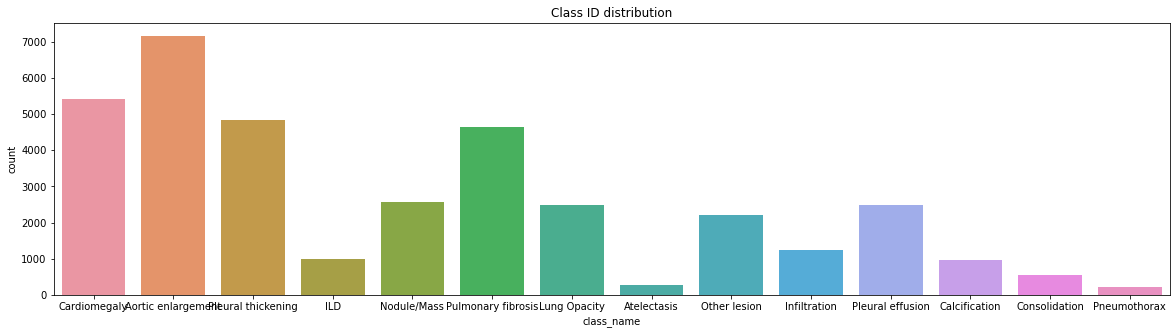

In [7]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'class_name', data = train_df)
plt.title('Class ID distribution')
plt.show()

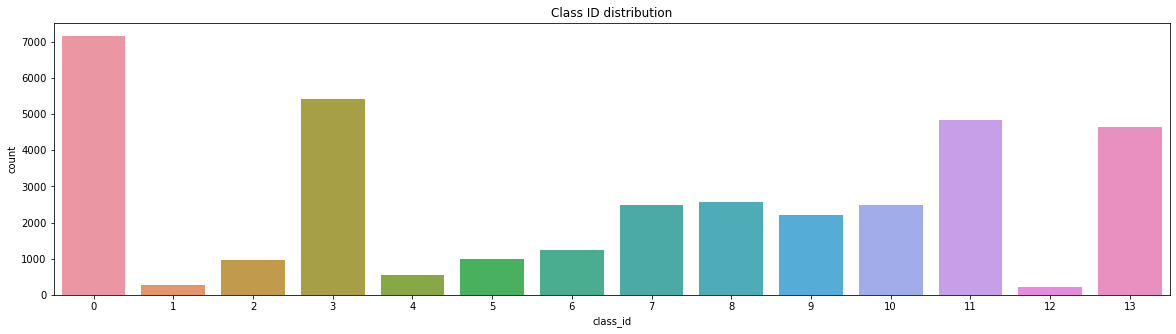

In [8]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'class_id', data = train_df)
plt.title('Class ID distribution')
plt.show()

We will only examine the data with abnormality! However, we can divide this challenge into 2 steps: step 1 will be classication model and the second one will be the object detection. 

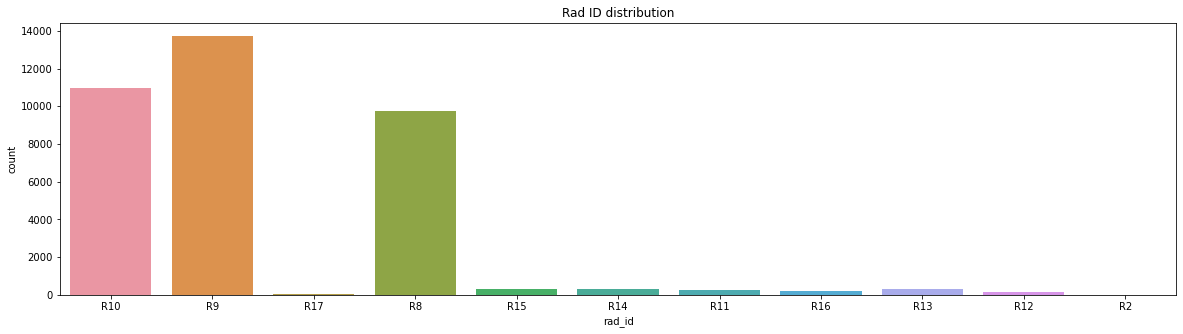

In [9]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'rad_id', data = train_df)
plt.title('Rad ID distribution')
plt.show()

In [10]:
print("Unique image_id in  train: ", train_df['image_id'].nunique())

Unique image_id in  train:  4394


**And only 4394 DICOM file contain abnormality**

In [11]:
train_df.groupby('class_id').image_id.count()

class_id
0     7162
1      279
2      960
3     5427
4      556
5     1000
6     1247
7     2483
8     2580
9     2203
10    2476
11    4842
12     226
13    4655
Name: image_id, dtype: int64

**Create balance dataset**

In [22]:
def get_balanced_train_df(filtered_df = train_df):
    balanced_train_df = pd.DataFrame()
    
    samples_per_class = 75
    for class_name in filtered_df.class_name.unique():
        balanced_train_df = balanced_train_df.append(filtered_df.query("class_name==@class_name")[:samples_per_class], 
                                                           ignore_index=True)
        
    return balanced_train_df

In [ ]:
balanced_train_df = get_balanced_train_df()
balanced_train_df

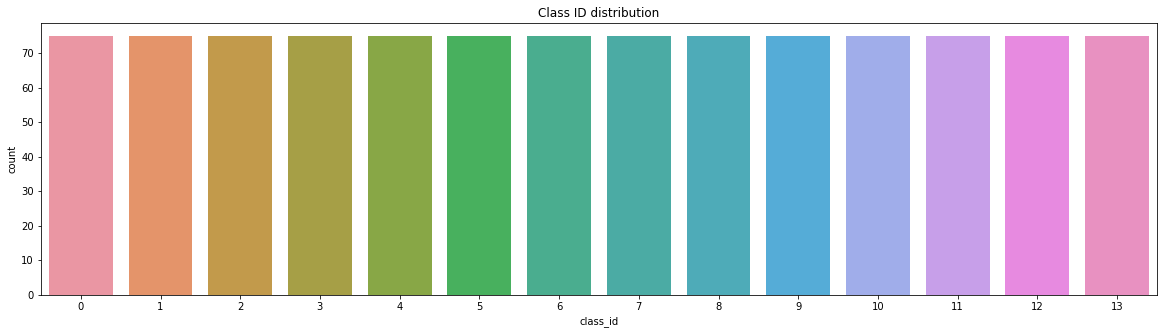

In [26]:
plt.figure(figsize=(20,5))
sns.countplot(x = 'class_id', data = balanced_train_df)
plt.title('Class ID distribution')
plt.show()

### Helper functions for converting bounding boxes to the right format for Mask RCNN

In [12]:
def get_mask(img_dimensions, x_min, y_min, x_max, y_max):
    img_height, img_width = img_dimensions
    img_mask = np.full((img_height,img_width),0)
    img_mask[y_min:y_max,x_min:x_max] = 255
    return img_mask.astype(np.float32)

def rle_encoding(x):
    dots = np.where(x.T.flatten() == 255)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

### Function convert DICOM data to np.array


In [13]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    dicom = pydicom.read_file(path)
    # VOI LUT (if available by DICOM device) is used to
    # transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data


# Accelarate cv2.imwrite 

In [14]:
import glob
import os
import cv2
import concurrent.futures

In [15]:
def generate_data(train_df_sample = train_df):
    diagnostic_per_image = []

    image_size=512
    with tqdm(total=len(train_df_sample)) as pbar:
        for idx,row in train_df_sample.iterrows():
            image_id = row.image_id
            image_df = train_df_sample.query("image_id==@image_id")
            class_list = []
            RLE_list = []

            for diagnostic_id, diagnostic in image_df.iterrows():
                class_list.append(diagnostic.class_id)

                dicom_image = dicom2array(TRAIN_DIR + '/' + image_id+".dicom")
                image_dimensions = dicom_image.shape

                resized_img = cv2.resize(dicom_image, (image_size,image_size), interpolation = cv2.INTER_AREA)

                os.chdir(PREPROCESSED_TRAINING_IMAGE_FOLDER)
                # print(PREPROCESSED_TRAINING_IMAGE_FOLDER+ image_id+ ".jpg")

                cv2.imwrite(PREPROCESSED_TRAINING_IMAGE_FOLDER+ image_id+ ".jpg", resized_img)

                mask = get_mask(image_dimensions, int(diagnostic.x_min), int(diagnostic.y_min), int(diagnostic.x_max), int(diagnostic.y_max))
                resized_mask = cv2.resize(mask, (image_size,image_size))
                RLE_list.append(rle_encoding(resized_mask))
            diagnostic_per_image.append({"image_id":image_id,
                                         "CategoryId":class_list,
                                         "EncodedPixels":RLE_list})
            pbar.update(1)
    return diagnostic_per_image

In [16]:
diagnostic_per_image = generate_data(train_df_sample = train_df[10000:])
# SAVING .CSV
os.chdir(PREPROCESSED_TRAINING_IMAGE_FOLDER)
image_size=512
samples_df = pd.DataFrame(diagnostic_per_image)
samples_df["Height"] = image_size
samples_df["Width"] = image_size
samples_df.head()
#
samples_df.to_csv('sample_df.csv', index=False)


  0%|          | 74/26096 [06:27<37:48:48,  5.23s/it]


KeyboardInterrupt: 

In [27]:
# SAVING .CSV
os.chdir(PREPROCESSED_TRAINING_IMAGE_FOLDER)
image_size=512
samples_df = pd.DataFrame(diagnostic_per_image)
samples_df["Height"] = image_size
samples_df["Width"] = image_size
samples_df.head()
#
samples_df.to_csv('sample_df.csv', index=False)